# Wikipedia feature engineering

The wikipedia part showcases our capabilities to extract features from Wikipedia using QIDs. Such features are gender, political assignation or age. Wikipedia data is quite messy and the heuristics used to extract these features are shown.

These features should prove useful to get interesting insights during Milestone 3.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from importlib import reload
import matplotlib.pyplot as plt
import urllib.request
import json
import sys
import re
import pickle


sys.path.append('../helpers/')
sys.path.append('../feature_engineering/')
import helpers

reload(helpers)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/lucastrg/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/lucastrg/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<module 'helpers' from '/home/lucastrg/FLEP/MA1/ADA/ada-2021-project-adada-sur-mon-bidet/notebooks/../helpers/helpers.py'>

## Pre-Processing
We will remove all the quotes without a speaker, and we will extract the set of all the speakers and QIDs of the sampled rows.
We then fetch a json of each speaker's whole page as well as all its PIDs and RIDs (these 2 IDs are not yet in use)

In [2]:
with open("../speaker_cache/cache.pickle", 'rb') as f:
    speaker_content = {}
    while 1:
        try:
            speaker_content = speaker_content | pickle.load(f)
        except EOFError:
            break
    

In [3]:
len(speaker_content)

59122

## Political Side assignation
Here we're guessing the political side of each speaker with somewhat good accuracy. We use 2 different strategies, if the speaker has a well filled in wikipedia page, we can simply find its current political party. If not, we're using a surprisingly alright heuristic, we simply count the occurences of words assigned to democrats (i.e. "left-wing", "liberal", ...) and republicans, and compare the 2 counts.

NB: There is obviously one major assumption that speaker belong exclusively to either of these two (or none). However, even in the US, some speakers are "in the middle". 

It should also be noted that some speakers are not American, we however found that our heuristic still matched those speakers with conservatives view to the Republican and vice-versa). We shall in the next milestone investigate further and perhaps adopt a deeper model.

In [4]:
def pol_compass_from_wiki(speakers_content, discrete = True):
    if discrete:
        dem_words=["democrat", "left-wing", "liberal"]
        rep_words =["republican", "conservative", "right-wing"]


        for speaker in speakers_content:
            yielded = False
            s= speakers_content[speaker].lower()

            for line in s.split("\n"):
                if "| party" in line:
                    if any(x in line for x in dem_words):
                        yield speaker, ("Democrat", -1)
                        yielded = True
                    elif any(x in line for x in rep_words):
                        yielded = True
                        yield speaker, ("Republican", -1)
                
            if not yielded:

                dem= sum(s.count(x) for x in dem_words)
                rep= sum(s.count(x) for x in rep_words)
                total = rep+dem
                if total:
                    yield speaker, ("Democrat" if dem>rep else "Republican", total)
    else:
        dem_words=["democrat", "left-wing", "liberal"]
        rep_words =["republican", "conservative", "right-wing"]

        for speaker in speakers_content:
            yielded = False
            s= speakers_content[speaker].lower()

            for line in s.split("\n"):
                if "| party" in line:
                    if any(x in line for x in dem_words):
                        yield speaker, (1,0, -1)
                        yielded = True
                    elif any(x in line for x in rep_words):
                        yielded = True
                        yield speaker, (0,1, -1)
                
            if not yielded:

                dem= sum(s.count(x) for x in dem_words)
                rep= sum(s.count(x) for x in rep_words)
                total = rep+dem
                if total:
                    yield speaker, (dem/total,rep/total, total)



In [5]:
speaker_wing= dict(pol_compass_from_wiki(speaker_content))
len(speaker_wing)

13212

## Gender assignation

In order to guess the gender if the speakers, we again use 2 strategies. At first, we try guessing the gender by counting occurences of gendered pronoums, but if we don't get any, we train a classifier, which solely uses the name of the speaker to guess the gender (thus with pretty bad accuracy ~70%) 

In [6]:
from nltk.corpus import names
from nltk import NaiveBayesClassifier as NBC
from nltk import classify
import nltk
nltk.download('names')

import random

[nltk_data] Downloading package names to /home/lucastrg/nltk_data...
[nltk_data]   Package names is already up-to-date!


For the classifier we use both the whole name as well as only the last letter

In [7]:
def gender_features(word):
    return {"whole name" : word, "lastletter" : word[-1]}

Training set loading and parsing

In [8]:
femaleNames = [ (name, "female") for name in names.words("female.txt") ]
maleNames = [ (name, "male") for name in names.words("male.txt") ]
allNames = maleNames + femaleNames
random.shuffle(allNames)

Actually training the classifier

In [9]:
featureData = [(gender_features(namelist), gender) for (namelist, gender) in allNames ]
test_data = featureData[:500]
train_data = featureData[500:]
classifier = NBC.train(train_data)

In [10]:
def gender_from_wiki(speaker_content):
    he_words=[" he ", " him", " him"] #The spaces are important, don't modify
    she_words =[" she ", " her"]
    they_words=[" they ", " them"]

    for speaker in speaker_content:
        s= speaker_content[speaker].lower()

        he= sum(s.count(x) for x in he_words)
        she= sum(s.count(x) for x in she_words)
        they= sum(s.count(x) for x in they_words)
        total = he+she+they

        if True:
            if total==0:
                 yield (speaker, classifier.classify(gender_features(speaker.split()[0])))
            elif he == max(he,she,they):
                yield(speaker, "male")
            elif she == max(he,she,they):
                yield(speaker, "female")
            else:
                yield(speaker, "other") 
        if False and total:
            yield speaker, (he/total,she/total, they/total, total)


In [11]:
speaker_gender = dict(gender_from_wiki(speaker_content))
len(speaker_gender)

59122

In [12]:
tmp = []
for speaker, gender in speaker_gender.items():
    tmp.append(gender)
np.unique(tmp, return_counts=True) #Snif

(array(['female', 'male', 'other'], dtype='<U6'), array([11763, 46848,   511]))

As we can see, only 20% of the speakers, are female.

## Age assignation
Much easier to do, we can most of the time get a solid birth date and compute the age of the speaker (not precisely, we only use the year, since we're more interested about seeing general trends rather than precise assignation)

In [13]:
def age_from_wiki(speaker_content):
    count = 0

    for speaker in speaker_content:
        s= speaker_content[speaker].lower().split("\n")
        for line in s:
            if "birth_date" in line:
                    
                    match = re.match("^(\|birth_date={{birthdateandage\|(\w*=\w*\|)?)([0-9]*)\|([0-9]*)\|([0-9]*)", line.replace(" ",""))
                    if match:
                        age = 2022-int(match.group(3))
                        yield(speaker, age)
                    else : 
                        match = re.match("^(\|birth_date={{birthdate\|(\w*=\w*\|)?)([0-9]*)\|([0-9]*)\|([0-9]*)", line.replace(" ",""))
                        if match:
                            age = 2022-int(match.group(3))
                            yield(speaker, age)
                        else :
                            match = re.match("^(\|birth_date={{birthyearandage\|(\w*=\w*\|)?)([0-9]*)", line.replace(" ",""))
                            if match:
                                age = 2022-int(match.group(3))
                                yield(speaker, age)     
                            else:
                                count +=1


In [ ]:
speaker_age = dict(age_from_wiki(speaker_content))

In [ ]:
len(speaker_age)

In [ ]:
plt.hist(speaker_age.values(), bins=20)
plt.title("Empirical age distribution of the sampled speakers (without filtering)")
plt.xlabel("Age")
plt.ylabel("Count")

In [ ]:
wing = []
ages = []
gender = []


for speaker in speaker_content:
    if speaker in speaker_age.keys() and speaker in speaker_gender.keys() and speaker in speaker_wing.keys() and speaker_age[speaker]<120:
 
        ages.append(speaker_age[speaker])
        wing.append(speaker_wing[speaker][0])
        gender.append(speaker_gender[speaker])


In [ ]:
plt.hist(wing)
plt.title("Observed repartition between the 2 parties")
plt.ylabel("Count")

In order to get a more precise view of the age of speakers that could have contributed to the climate change question, we filtered speakers over 120 years old

In [ ]:
plt.hist(ages,bins=20)
plt.title("Empirical age distribution of the sampled speakers (with a bit of filtering)")
plt.xlabel("Age")
plt.ylabel("Count")

In [ ]:
big_dict={}
for speaker in speaker_content:
    if speaker in speaker_age.keys() and speaker in speaker_gender.keys() and speaker in speaker_wing.keys() and speaker_age[speaker]<120:
        big_dict[speaker]=(speaker_age[speaker], speaker_gender[speaker], speaker_wing[speaker][0],speaker_wing[speaker][1])
        

In [ ]:
df = pd.DataFrame.from_dict(big_dict, orient="index", columns=["age", "gender", "wing", "political_count"])

In [ ]:
df.wing = df.wing.astype( "category")
df.gender = df.gender.astype("category")

Text(0.5, 0.98, 'Age and gender distribution for each major political wing')

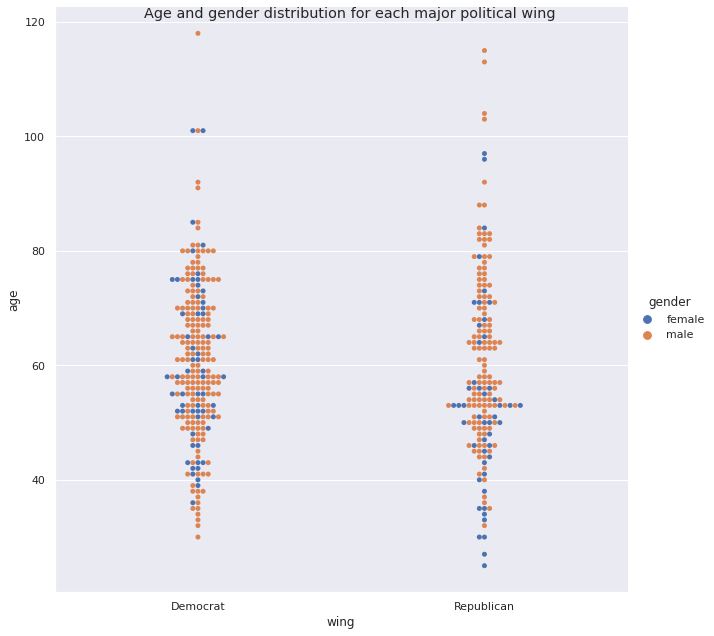

In [ ]:
sns.set(rc={'figure.figsize':(20,12)})
sns.catplot(x="wing", y="age", hue="gender", kind="swarm", data=df, height=9).fig.suptitle("Age and gender distribution for each major political wing")

Text(0.5, 1.0, 'Age distribution of each major political wing')

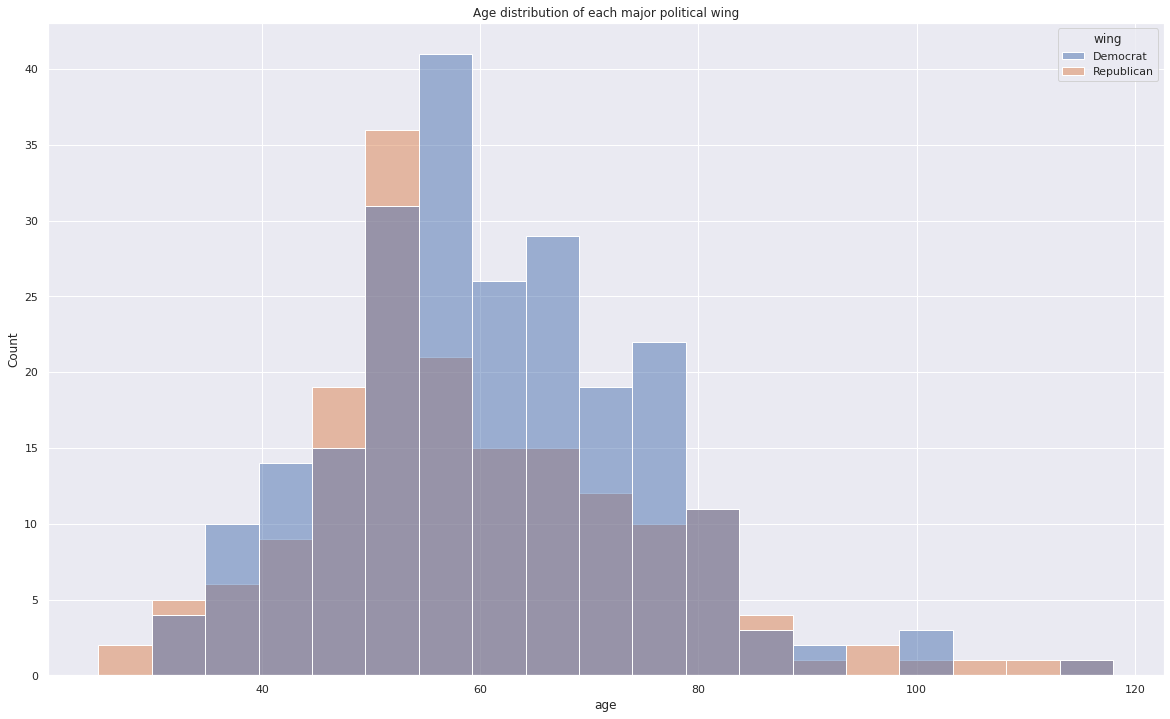

In [ ]:
sns.histplot(data=df, x="age", hue="wing").set_title("Age distribution of each major political wing")

Text(0.5, 1.0, 'Age distribution of each assigned gender')

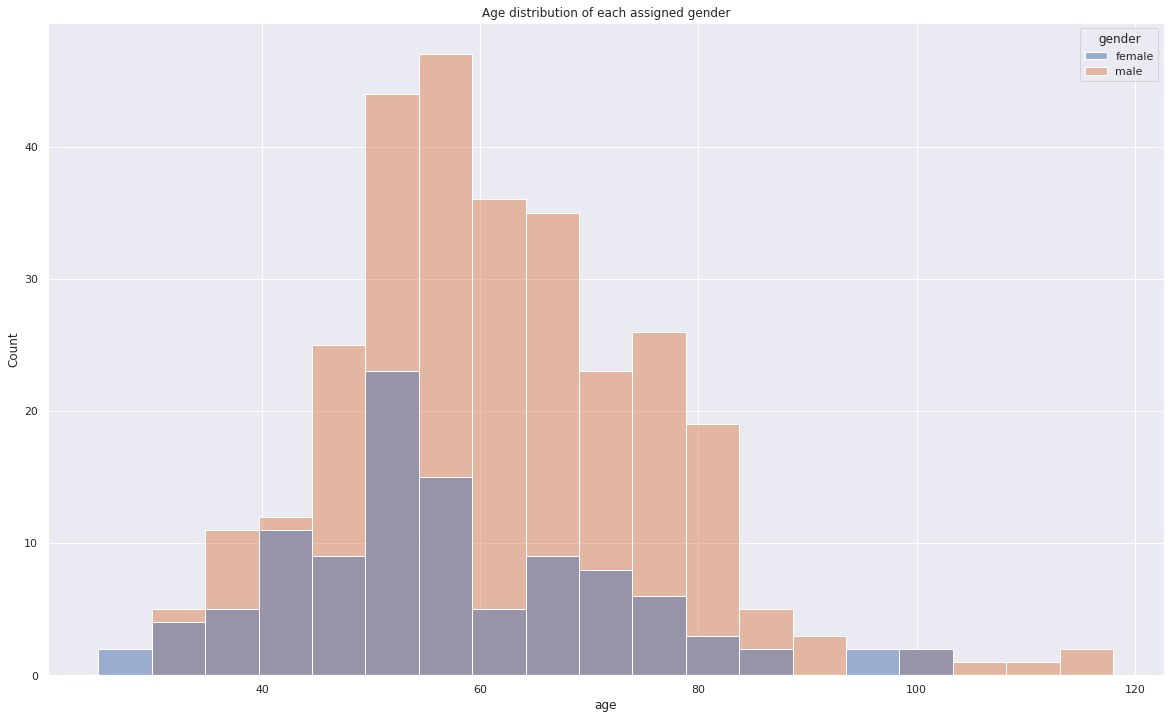

In [ ]:
sns.histplot(data=df, x="age", hue="gender").set_title("Age distribution of each assigned gender")